### GAN (Generative Adversarial Network)

In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import random

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.figsize': (8,8)})
matplotlib.rcParams["axes.grid"] = True

In [2]:
print('pandas    : ',pd.__version__)
print('numpy     : ',np.__version__)
print('matplotlib: ',matplotlib.__version__)

pandas    :  1.1.0
numpy     :  1.18.3
matplotlib:  3.3.1


In [3]:
xs = np.linspace(-10, 10, num=40, endpoint=True)
def gen_y(xs):
    return [(math.sin(x)/x)-(x/10) for x in xs]

In [4]:
def segment():
    s = random.uniform(-10, 7.5)
    x = np.linspace(s, s+2.5, num=5, endpoint=True)
    return x, gen_y(x)

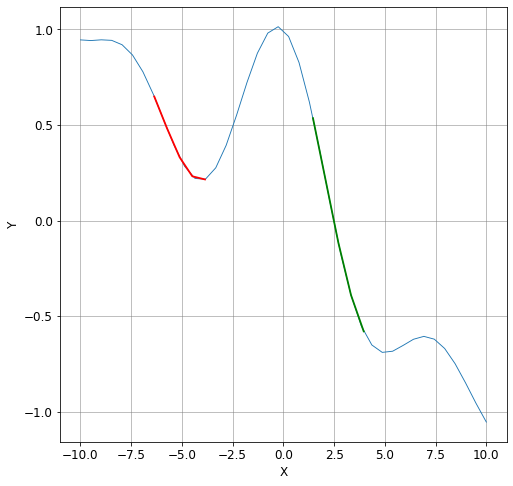

In [5]:
plt.plot(xs, gen_y(xs), lw=0.9)
x1, y1 = segment()
plt.plot(x1, y1, color = 'g', linewidth = 1.8)
x2, y2 = segment()
plt.plot(x2, y2, color = 'r', linewidth = 1.8)
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.show()

In [6]:
x, y = segment()
x

array([-3.33152974, -2.70652974, -2.08152974, -1.45652974, -0.83152974])

In [7]:
y

[0.2764831764588012,
 0.42637542743310014,
 0.6272611987773606,
 0.8277390616912634,
 0.9718318216605888]

In [8]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [9]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))

x = [random.uniform(-6, 6) for x in range(train_data_length)]
y = [(math.sin(xs)/xs)-(xs/10) for xs in x]

train_data[:,0] = torch.FloatTensor(x)
train_data[:,1] = torch.FloatTensor(y)

train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

In [10]:
train_set[:5]

[(tensor([ 5.8955, -0.6537]), tensor(0.)),
 (tensor([-1.5822,  0.7902]), tensor(0.)),
 (tensor([ 3.5309, -0.4606]), tensor(0.)),
 (tensor([ 5.4816, -0.6792]), tensor(0.)),
 (tensor([-5.2476,  0.3608]), tensor(0.))]

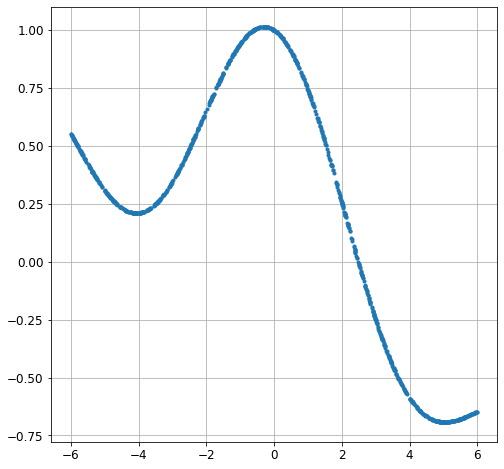

In [11]:
plt.figure(figsize=(8,8))
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [139]:
# Создадим загрузчик данных, который будет перетасовывать данные из train_set
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [127]:
# Дескриминатор
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()

In [128]:
# Генератор
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [140]:
lr = 0.00075
num_epochs = 200
loss_function = nn.BCELoss()
#loss_function = nn.MSELoss()
#loss_function = nn.L1Loss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        
        G_losses.append(loss_generator.item())
        D_losses.append(loss_discriminator.item())

        # Выводим значения функций потерь
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch:3d} Loss D.: {loss_discriminator:.6f}  Loss G.: {loss_generator:.6f}")

Epoch:   0 Loss D.: 0.696754  Loss G.: 0.685161
Epoch:  10 Loss D.: 0.705725  Loss G.: 0.625957
Epoch:  20 Loss D.: 0.690402  Loss G.: 0.693063
Epoch:  30 Loss D.: 0.690817  Loss G.: 0.714711
Epoch:  40 Loss D.: 0.688141  Loss G.: 0.704479
Epoch:  50 Loss D.: 0.685578  Loss G.: 0.690545
Epoch:  60 Loss D.: 0.734524  Loss G.: 0.706408
Epoch:  70 Loss D.: 0.706000  Loss G.: 0.672691
Epoch:  80 Loss D.: 0.714038  Loss G.: 0.701415
Epoch:  90 Loss D.: 0.693776  Loss G.: 0.672804
Epoch: 100 Loss D.: 0.696663  Loss G.: 0.701387
Epoch: 110 Loss D.: 0.696970  Loss G.: 0.707143
Epoch: 120 Loss D.: 0.685449  Loss G.: 0.692522
Epoch: 130 Loss D.: 0.688363  Loss G.: 0.692205
Epoch: 140 Loss D.: 0.726638  Loss G.: 0.651123
Epoch: 150 Loss D.: 0.620217  Loss G.: 0.797975
Epoch: 160 Loss D.: 0.688360  Loss G.: 0.707676
Epoch: 170 Loss D.: 0.684714  Loss G.: 0.705152
Epoch: 180 Loss D.: 0.693406  Loss G.: 0.683961
Epoch: 190 Loss D.: 0.699457  Loss G.: 0.695989


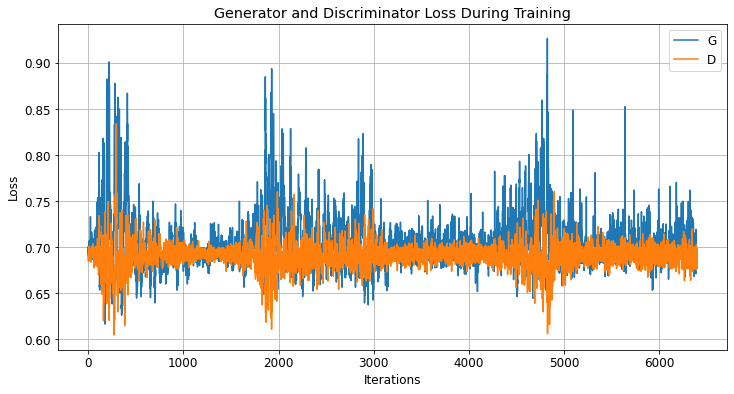

In [141]:
plt.figure(figsize=(12,6))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [142]:
# Вызов генератора для получения новых данных
latent_space_samples = torch.randn(240, 2)
generated_samples = generator(latent_space_samples)

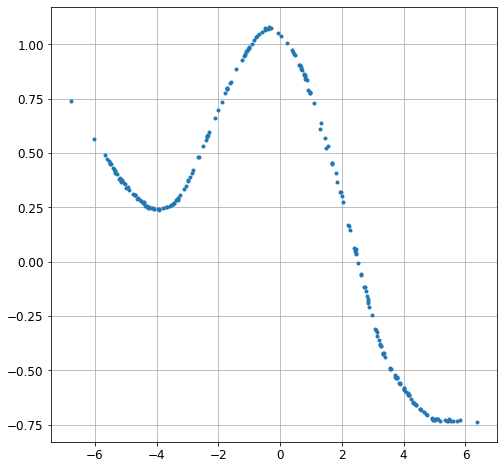

In [143]:
# Построим сгенерированные данные и проверим, насколько они похожи на обучающие данные.
generated_samples = generated_samples.detach()
plt.figure(figsize=(8,8))
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")